In [2]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as trans
from torchvision.models import resnet18, resnet34, resnet50, mobilenet_v2, vgg16, vgg19
from torch.optim.lr_scheduler import OneCycleLR

from tqdm import tqdm
import numpy as np
from typing import *
import os
from datetime import datetime
import pickle

Tensor = torch.Tensor
Module = torch.nn.Module
Optimizer = torch.nn.optim.Optimizer
DataLoader = torch.utils.data.DataLoader

# Parameters

In [8]:
# The path to dataset
data_path = "/home/jimmy/Data/CIFAR_100"
# cuda or cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# hyper-parameters
batch_size = 128 #256
init_lr = 1e-3
weight_decay = 1e-5
n_epochs = 50

# Data and Dataset

In [4]:
def collectFunc(batch_list: List[Tuple[Tensor, Tensor]]) -> Tuple[Tensor, Tensor]:
    imgs = []
    targets = []
    for item in batch_list:
        imgs.append(item[0])
        targets.append(item[1])
    return torch.stack(imgs), torch.stack(targets)


class CIFAR100Dataset(Dataset):
    # Here define some data augmentation transformation
    trans_train = trans.Compose([
        trans.RandomHorizontalFlip(),
        trans.RandomCrop(32, padding=4, padding_mode="reflect"),
        trans.Lambda(lambda img: img + (torch.rand_like(img) - 0.5) / 10),     # noise, 往图像里加随机noise，为了让performance更好
        trans.Lambda(lambda img: img + torch.rand(1, device=device) / 5 - 0.1),    # Brightness,更改图像亮度 随机
        trans.Lambda(lambda img: img * (torch.rand(1, device=device) / 5 + 0.9)),    # Contrast， 随机更改图像的对比度， 防止overfit，考试问题
    ])

    def __init__(self, custom_data_path: str=None, is_test: bool=False):
        self.is_test = is_test

        if custom_data_path is None:
            custom_data_path = data_path

        dataset_path = os.path.join(custom_data_path, "test" if is_test else "train")
        with open(dataset_path, 'rb') as in_file:
            data_dict = pickle.load(in_file, encoding='bytes')
        self.inputs = data_dict[b"data"]
        n_data = self.inputs.shape[0]
        small_class_ids = data_dict[b"fine_labels"]
        super_class_ids = data_dict[b"coarse_labels"]

        # data size: (50000, 3, 32, 32)
        self.inputs = torch.tensor(self.inputs, dtype=torch.float32).view(n_data, 3, 32, 32)
        # data normalization
        self.inputs = self.inputs / 255
        self.inputs[:, 0] = (self.inputs[:, 0] - 0.5074) / 0.2011
        self.inputs[:, 1] = (self.inputs[:, 1] - 0.4867) / 0.1987
        self.inputs[:, 2] = (self.inputs[:, 2] - 0.4411) / 0.2025

        # 100 detailed categories
        self.small_class = torch.tensor(small_class_ids, dtype=torch.long)
        
        # 20 super categories
        self.super_class = torch.zeros(n_data, 20, dtype=torch.float32)
        self.super_class[torch.arange(n_data), super_class_ids] = 1     # (50000, 20)

        meta_path = os.path.join(custom_data_path, "meta")
        with open(meta_path, 'rb') as in_file:
            metadata_dict = pickle.load(in_file, encoding='bytes')
        self.smallclass_to_name = dict(list(enumerate(metadata_dict[b'fine_label_names'])))
        self.superclass_to_name = dict(list(enumerate(metadata_dict[b'coarse_label_names'])))

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        img = self.inputs[idx].to(device)
        target = self.small_class[idx].to(device)

        if not self.is_test:
            img = self.trans_train(img)
        return img, target

# Model

In [5]:
def saveModel(path: str, **models: torch.nn.Module):
    # Save models
    torch.save({name: model.state_dict() for name, model in models.items()}, path)
        
def loadModel(path: str, **models: torch.nn.Module):
    # Load models from path
    for model_name, model in models.items():
        model.load_state_dict(torch.load(path))

# Define multiple models
# I may only use 5 of them
models = {
    "resnet18": resnet18(pretrained=False, num_classes=100).to(device),
    "resnet34": resnet34(pretrained=False, num_classes=100).to(device),
    "resnet50": resnet50(pretrained=False, num_classes=100).to(device),
    "mobilenet_v2": mobilenet_v2(pretrained=False, num_classes=100).to(device),
    "vgg16": vgg16(pretrained=False, num_classes=100).to(device),
    "vgg19": vgg19(pretrained=False, num_classes=100).to(device)
}

/home/jimmy/anaconda3/envs/Py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jimmy/anaconda3/envs/Py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jimmy/anaconda3/envs/Py311/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


# Train and Eval

In [6]:
def train_epoch(
    model_name: str, 
    model: Module, 
    optimizer: Optimizer, 
    criterion: Module, 
    train_loader: DataLoader, 
    epoch: int) -> Tuple[float, float]:
    
    model.train()
    total_loss = 0
    total_correct = 0
    total_data = 0
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Train Model {model_name} Epoch {epoch}")
    for idx, (inputs, targets) in enumerate(pbar):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == targets).sum().item()
        total_data += targets.shape[0]
        
        pbar.set_postfix_str(f"Loss={total_loss / total_data:.4f} Acc={total_correct / total_data:.4f}")

    return total_loss / total_data, total_correct / total_data


def eval_epoch(model_name: str, model: Module, criterion: Module, val_loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    total_loss = 0
    total_correct = 0
    total_data = 0
    with torch.no_grad():
        pbar = tqdm(val_loader, total=len(val_loader), desc=f"Eval Model {model_name}")
        for idx, (inputs, targets) in enumerate(pbar):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()
            total_data += targets.shape[0]
            
            pbar.set_postfix_str(f"Loss={total_loss / total_data:.4f} Acc={total_correct / total_data:.4f}")

    return total_loss / total_data, total_correct / total_data

# Run

In [9]:
train_set = CIFAR100Dataset(data_path, is_test=False)
val_set = CIFAR100Dataset(data_path, is_test=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collectFunc)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collectFunc)

loss_func = torch.nn.CrossEntropyLoss()

# Create logginga and saving folder
program_start_time = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"./Runs/{program_start_time}/"
os.mkdir("Runs")
os.mkdir(save_path)

# Write table column titles to Log.csv
with open(f"{save_path}/Log.csv", 'a') as out_file:
    out_file.write("Model,Epoch,Train Loss,Train Acc,Val Loss,Val Acc\n")

# Train each model
for model_name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    schedular = OneCycleLR(optimizer, init_lr, epochs=n_epochs, steps_per_epoch=len(train_loader))
    
    best_loss_so_far = 1e9

    # train & eval loop
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model_name, model, optimizer, loss_func, train_loader, epoch)
        val_loss, val_acc = eval_epoch(model_name, model, loss_func, val_loader)

        # Write train & eval results
        with open(f"{save_path}/Log.csv", 'a') as out_file:
            out_file.write(f"{model_name},{epoch},{train_loss},{train_acc},{val_loss},{val_acc}\n")

        saveModel(f"{save_path}/{model_name}_last.pth", **{model_name: model})
        if val_loss < best_loss_so_far:
            best_loss_so_far = val_loss
            saveModel(f"{save_path}/{model_name}_best.pth", **{model_name: model})
        
        

Train Model inception_v3 Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

# Result Analysis

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

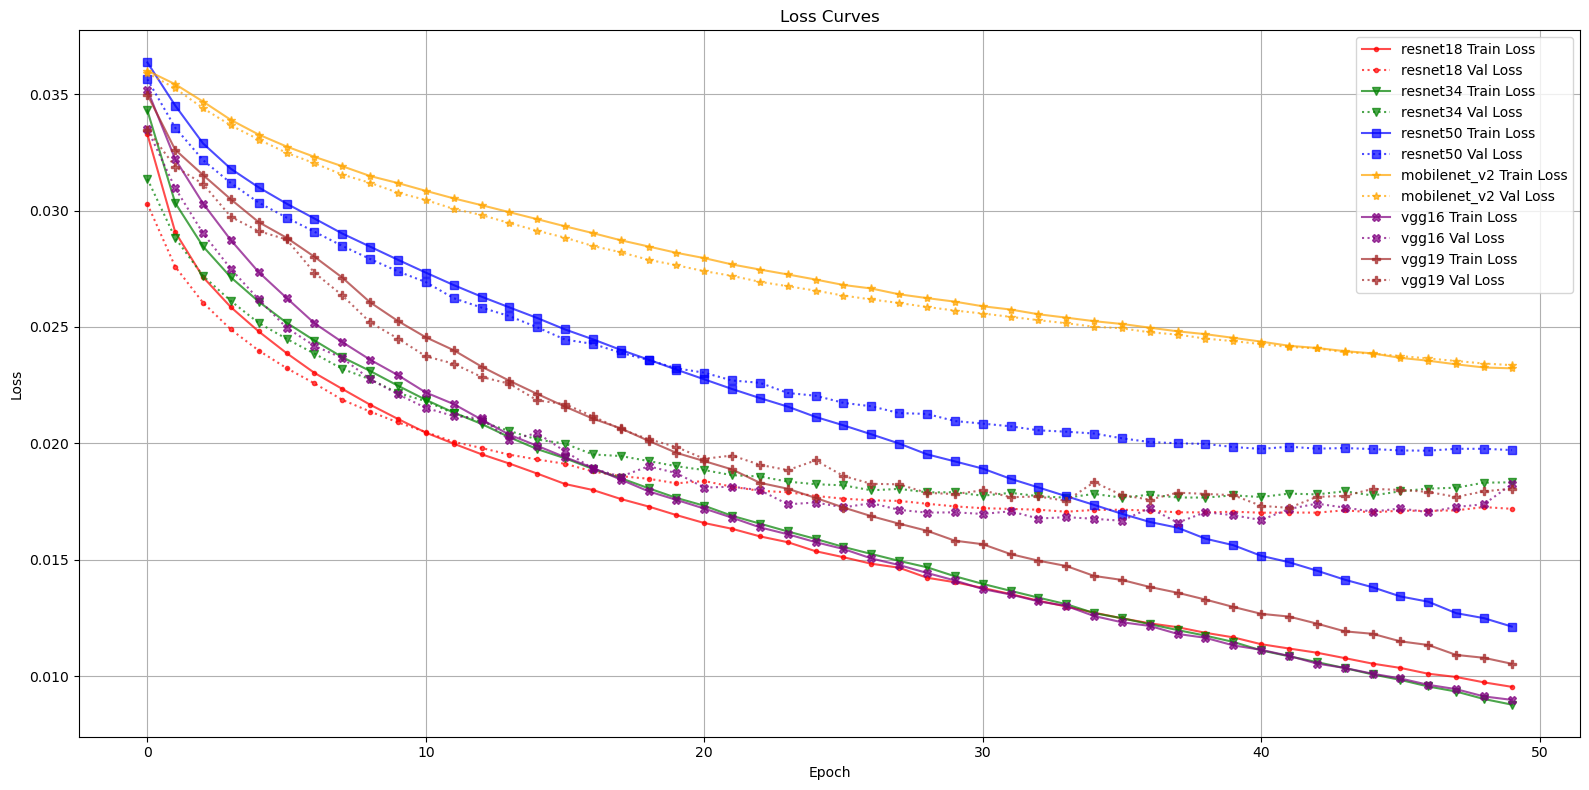

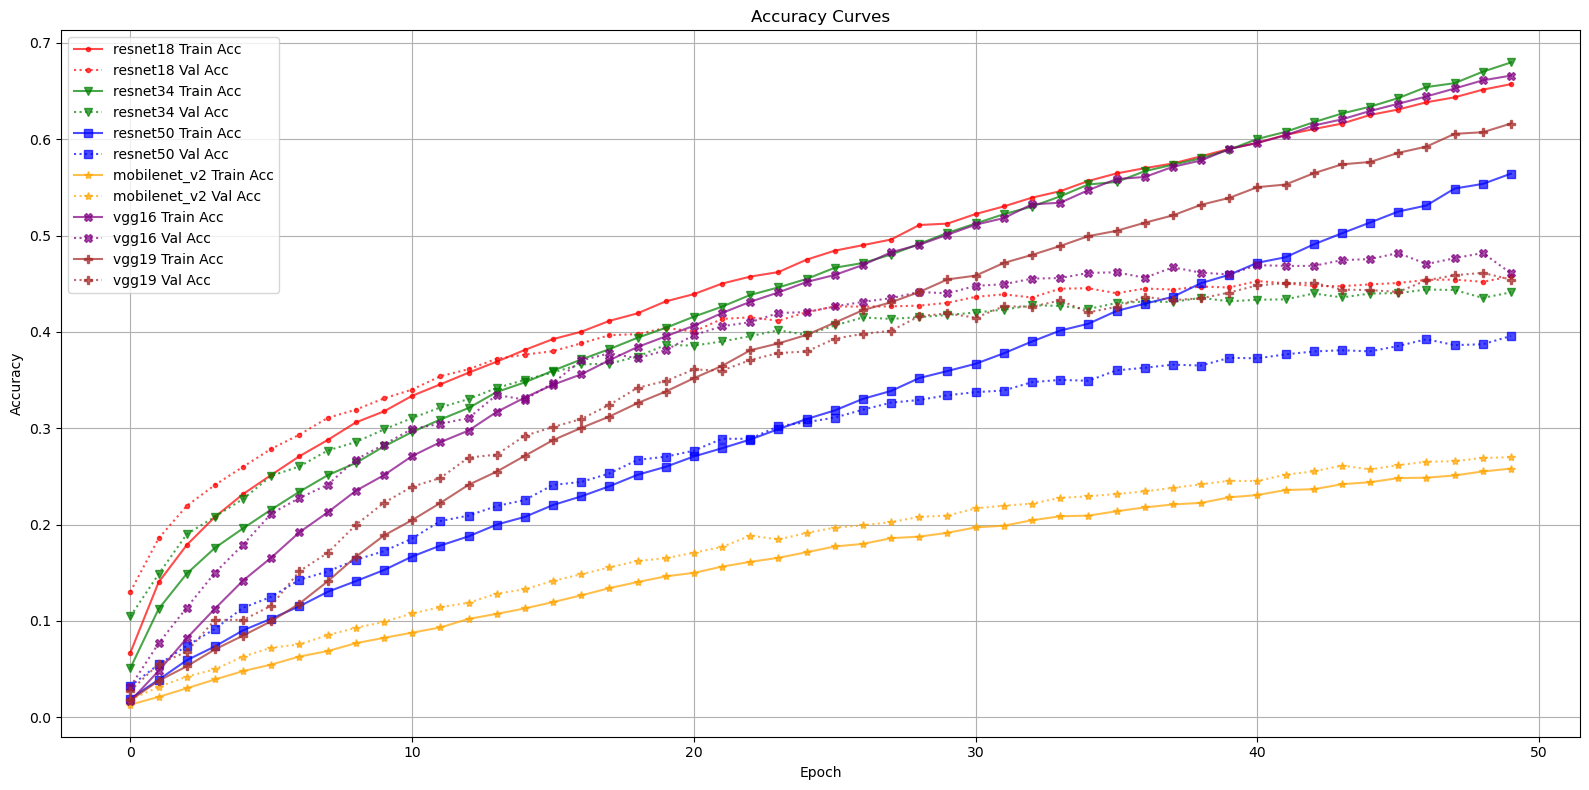

In [17]:
result_path = f"{save_path}/Log.csv"

df = pd.read_csv(result_path)

# Define markers and colors
markers = [".", "v", "s", "*", "X", "P", "D"]
colors = ["red", "green", "blue", "orange", "purple", "brown", "pink"]

# Draw first plot: loss curves
plt.figure(figsize=(16, 8))
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
for i, model_name in enumerate(df["Model"].unique()):
    model_df = df[df["Model"] == model_name]
    plt.plot(model_df["Epoch"], model_df["Train Loss"], 
             label=f"{model_name} Train Loss", marker=markers[i], color=colors[i], alpha=0.7)
    plt.plot(model_df["Epoch"], model_df["Val Loss"], 
             label=f"{model_name} Val Loss", marker=markers[i], color=colors[i], linestyle="dotted", alpha=0.7)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{save_path}/Loss_Curves.png", dpi=200)
plt.show()

# Draw second plot: accuracy curves
plt.figure(figsize=(16, 8))
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
for i, model_name in enumerate(df["Model"].unique()):
    model_df = df[df["Model"] == model_name]
    plt.plot(model_df["Epoch"], model_df["Train Acc"], 
             label=f"{model_name} Train Acc", marker=markers[i], color=colors[i], alpha=0.7)
    plt.plot(model_df["Epoch"], model_df["Val Acc"], 
             label=f"{model_name} Val Acc", marker=markers[i], color=colors[i], linestyle="dotted", alpha=0.7)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{save_path}/Accuracy_Curves.png", dpi=200)
plt.show()

# Key Observations
- Top3 for training: Resnet-34, VGG-16, Resnet-18.
- Top3 for validation: Resnet-18, VGG-16, VGG-19.
- Larger models perform worse at the beginning compare to smaller models, but they quickly catch up.
- Mobilenet-v2 performs the worst. (maybe because the number of parameters is too few, mobilenet aims to achieve very low cost inference, so it may not be as strong as other models)
- Resnet-34 experiences the greatest overfitting, its training loss and accuracy is top 1, but validation loss and accuracy are at 4th.